### Effective Radius Comparison

Compare forward model with different wavelengths and reffs.

In [1]:
#imports

import at3d
import numpy as np
import xarray as xr
from collections import OrderedDict
import pylab as py
np.random.seed(1)

cloud_scatterer = at3d.util.load_from_csv('/Users/khargenr/AT3D/at3d/data/synthetic_cloud_fields/jpl_les/rico32x37x26.txt',
                                           density='lwc',origin=(0.0,0.0))

#load atmosphere
atmosphere = xr.open_dataset('/Users/khargenr/AT3D/at3d/data/ancillary/AFGL_summer_mid_lat.nc')
#subset the atmosphere, choose only the bottom four km.
reduced_atmosphere = atmosphere.sel({'z': atmosphere.coords['z'].data[atmosphere.coords['z'].data <= 4.0]})
#merge the atmosphere and cloud z coordinates
merged_z_coordinate = at3d.grid.combine_z_coordinates([reduced_atmosphere,cloud_scatterer])

# define the property grid - which is equivalent to the base RTE grid
rte_grid = at3d.grid.make_grid(cloud_scatterer.x.diff('x')[0],cloud_scatterer.x.data.size,
                          cloud_scatterer.y.diff('y')[0],cloud_scatterer.y.data.size,
                          cloud_scatterer.z.data)

#finish defining microphysics because we can.

cloud_scatterer_on_rte_grid = at3d.grid.resample_onto_grid(rte_grid, cloud_scatterer)

#We choose a gamma size distribution and therefore need to define a 'veff' variable.
size_distribution_function = at3d.size_distribution.gamma

cloud_scatterer_on_rte_grid['veff'] = (cloud_scatterer_on_rte_grid.reff.dims,
                                       np.full_like(cloud_scatterer_on_rte_grid.reff.data, fill_value=0.1))
cloud_scatterer_on_rte_grid['reff'] = (cloud_scatterer_on_rte_grid.reff.dims,
                                       np.full_like(cloud_scatterer_on_rte_grid.reff.data, fill_value=10))

Save mie tables

In [2]:
# for wavelength in wavelengths:
#     mie_mono_tables[wavelength].to_netcdf(path='../mie_tables/' + str(wavelength) + '_mie_table.nc')

### USE DIFFERENT R_e and LWC MULTIPLICITY

In [3]:
multiplicities = [1, 1.5]
cloud_scatterers = []
for multiplicity in multiplicities:
    temp_cloud_scatterer_on_rte_grid = cloud_scatterer_on_rte_grid.copy()
    temp_cloud_scatterer_on_rte_grid.reff.data = cloud_scatterer_on_rte_grid.reff.data * multiplicity
    temp_cloud_scatterer_on_rte_grid.density.data = cloud_scatterer_on_rte_grid.density.data * multiplicity
    cloud_scatterers.append(temp_cloud_scatterer_on_rte_grid)

In [4]:
sensor_dicts_2D = []
wavelengths = [.470, .660, 1.640, 2.130]#.865, 1.240, 1.640, 2.130] 
sensor_zenith_list = [60.0, 0.0, 60.0]
sensor_azimuth_list = [65.0, 0.0, 65+180.0]
for cloud_scatterer in cloud_scatterers:
    sensor_dicts = []
    for zenith,azimuth in zip(sensor_zenith_list,sensor_azimuth_list):
        sensor_dict = at3d.containers.SensorsDict()
        for wavelength in wavelengths:
            sensor_dict.add_sensor('MSPI', 
                    at3d.sensor.orthographic_projection(wavelength, cloud_scatterer,0.02,0.02, azimuth, zenith,
                                             altitude='TOA', stokes='I'))
        sensor_dicts.append(sensor_dict)
    sensor_dicts_2D.append(sensor_dicts)

In [5]:
mie_mono_tables = OrderedDict()
for wavelength in wavelengths:
    mie_mono_tables[wavelength] = at3d.mie.get_mono_table(
        'Water',(wavelength,wavelength),
        max_integration_radius=65.0,
        minimum_effective_radius=0.1,
        relative_dir='../../mie_tables',
        verbose=False
    )

In [6]:
optical_property_generator = at3d.medium.OpticalPropertyGenerator(
    'cloud', 
    mie_mono_tables,
    size_distribution_function,
    reff=np.linspace(5.0,45,40),
    veff=np.linspace(0.03,0.37,18),
)
optical_properties = []
for cloud_scatterer in cloud_scatterers:
    optical_properties.append(optical_property_generator(cloud_scatterer))

In [7]:
# one function to generate rayleigh scattering.
rayleigh_scattering = at3d.rayleigh.to_grid(wavelengths,atmosphere,rte_grid)

In [8]:
solver_dicts_2D = []
for i, sensor_dicts in enumerate(sensor_dicts_2D):
    solver_dicts = []
    for sensor_dict in sensor_dicts:
        solvers_dict = at3d.containers.SolversDict()
        # note we could set solver dependent surfaces / sources / numerical_config here
        # just as we have got solver dependent optical properties.
        
        for wavelength in sensor_dict.get_unique_solvers():
            medium = {
                'cloud': optical_properties[i][wavelength],
                'rayleigh':rayleigh_scattering[wavelength]
             }
            config = at3d.configuration.get_config()
            solvers_dict.add_solver(
                wavelength,
                at3d.solver.RTE(
                    numerical_params=config,
                    surface=at3d.surface.lambertian(0.0),
                    source=at3d.source.solar(wavelength, 0.5,0.0),
                    medium=medium,
                    num_stokes=1#sensor_dict.get_minimum_stokes()[wavelength],
                )                   
            )
        solver_dicts.append(solvers_dict)
    solver_dicts_2D.append(solver_dicts)

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '73'. Max cell optical depth: '2.6781132221221924'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '92'. Max cell optical depth: '2.7872467041015625'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '193'. Max cell optical depth: '3.343541145324707'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: 

In [9]:
%%time
for i, sensor_dicts in enumerate(sensor_dicts_2D):
    for j, sensor_dict in enumerate(sensor_dicts):
        # solve the 4 RTEs in parallel AND get the measurements.
        sensor_dict.get_measurements(solver_dicts_2D[i][j], n_jobs=4, verbose=True)

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 2.130 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.470 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.640 micron]
     1  -0.726  0.452E+00    30784    40.64  0.159   [Radiance 0.470 micron]
     1  -0.717  0.457E+00    30784    40.64  0.159   [Radiance 0.660 micron]
     1  -0.659  0.404E+00    30784    40.64  0.159   [Radiance 2.130 micron]
     1  -0.687  0.435E+00    30784    40.64  0.159   [Radiance 1.640 micron]
     2  -1.329  0.492E+00    30784    40.64  0.159   [Radiance 0.470 micron]
     2  -1.321  0.497E+00    30784    40.64  0.159   [Radiance 0.660 micron]
     2  -1.034  0.464E+00    30784    40.64  0.159   [Radiance 2.130 micron]
     2  -1.116  0.487E+00    30784    40.64  0.159   [Radiance 1.640 micron]
     3  -1.593  0.516E+00    30784    40.64  0.159   [Radiance 0.470 micron]
     3  -1.

In [53]:
import matplotlib.colors as mcolors

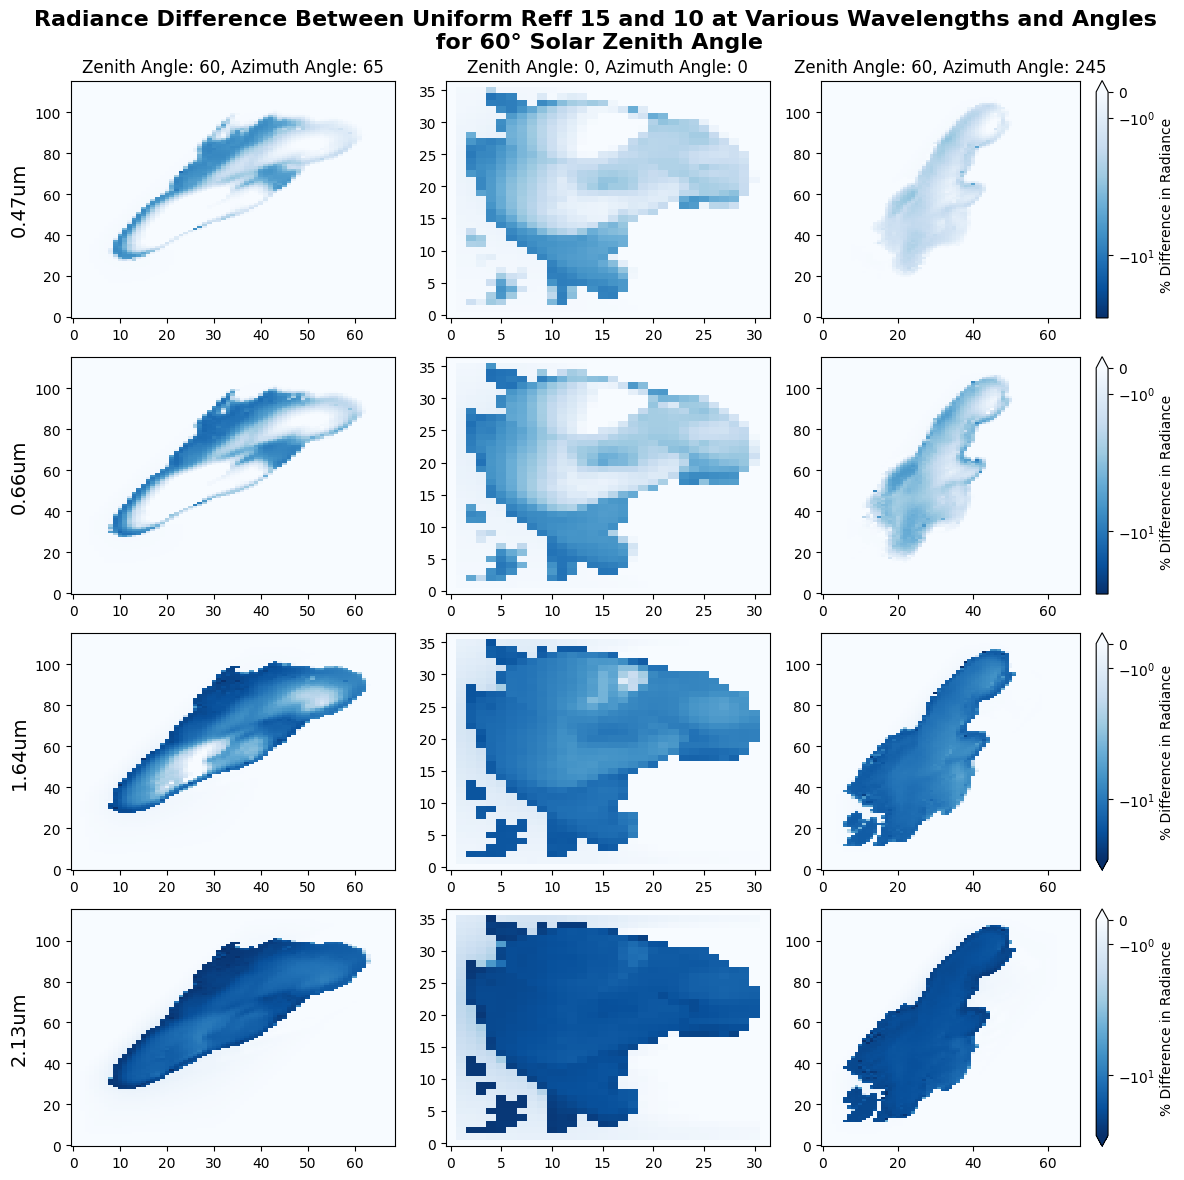

In [91]:
cmap = "Blues_r"
images_3D = []
for sensor_dicts in sensor_dicts_2D:
    images_per_reff = []
    for sensor_dict in sensor_dicts:
        images_per_angle = []
        for image in sensor_dict.get_images("MSPI"):
            images_per_angle.append(image.I.T)
        images_per_reff.append(images_per_angle)
    images_3D.append(images_per_reff)
transpose = np.swapaxes(images_3D, 0, 2) # sensor_dicts_2D : reff x angle x wavelength | transpose : wavelength x angle x reff
transpose = np.swapaxes(transpose, 1, 2) # transpose : wavelength x angle x reff | transpose : wavelength x reff x angle
fig, axs = py.subplots(4, 3, figsize=(12, 12))  # Create a figure with subplots side by side
py.suptitle("Radiance Difference Between Uniform Reff 15 and 10 at Various Wavelengths and Angles\n for 60\N{DEGREE SIGN} Solar Zenith Angle", fontsize = 16, fontweight = 'bold')
for i,sensor_dicts in enumerate(transpose):
    reff_10 = sensor_dicts[0]
    reff_15 = sensor_dicts[1]
    for j in range(3):
        plot = ((reff_15[j]-reff_10[j]) / reff_10[j] * 100).plot(ax = axs[i,j],cmap=cmap, norm=mcolors.SymLogNorm(linthresh = 5, vmin = -35, vmax = 0))
        if j == 2:
            colorbar = plot.colorbar
            colorbar.set_label("% Difference in Radiance")
        else:
            plot.colorbar.remove()
        axs[i, j].set_xlabel("")
        axs[i, j].set_ylabel("")
        if i == 0:
            axs[i, j].set_title("Zenith Angle: " + str(int(sensor_zenith_list[j])) + ", Azimuth Angle: " + str(int(sensor_azimuth_list[j])), fontsize=12)
        if j == 0:
            axs[i, j].set_ylabel(str(wavelengths[i]) + "um", fontsize=14)
py.tight_layout()  # Adjust layout for better spacing
py.show()

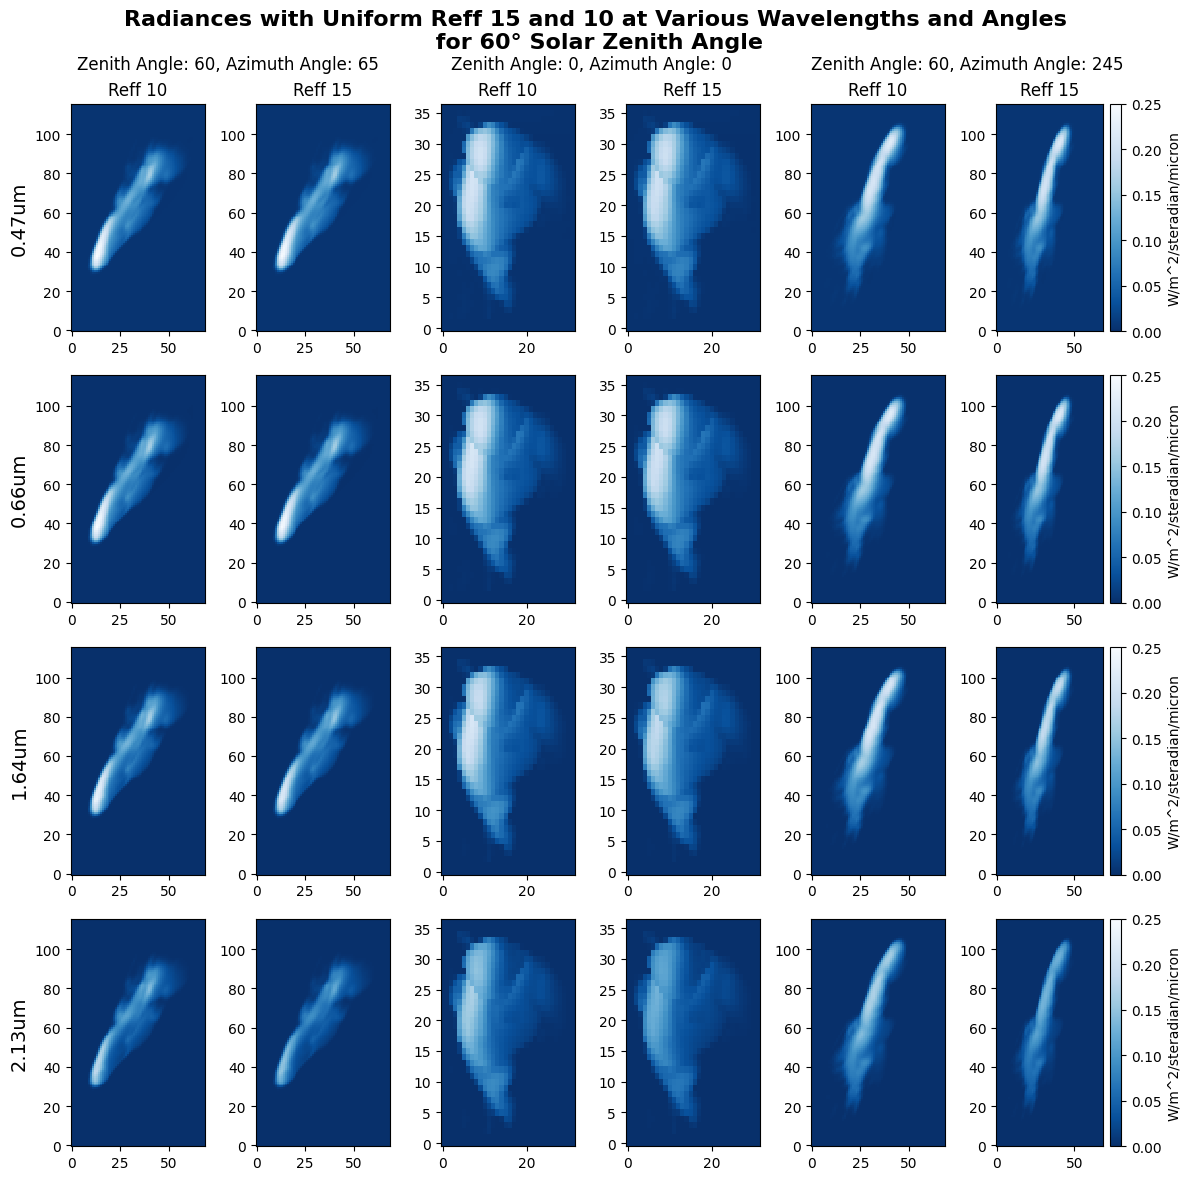

In [119]:
cmap = "Blues_r"
images_3D = []
for sensor_dicts in sensor_dicts_2D:
    images_per_reff = []
    for sensor_dict in sensor_dicts:
        images_per_angle = []
        for image in sensor_dict.get_images("MSPI"):
            images_per_angle.append(image.I.T)
        images_per_reff.append(images_per_angle)
    images_3D.append(images_per_reff)
transpose = np.swapaxes(images_3D, 0, 2) # sensor_dicts_2D : reff x angle x wavelength | transpose : wavelength x angle x reff
transpose = np.swapaxes(transpose, 1, 2) # transpose : wavelength x angle x reff | transpose : wavelength x reff x angle
fig, axs = py.subplots(4, 6, figsize=(12, 12))  # Create a figure with subplots side by side
py.suptitle("Radiances with Uniform Reff 15 and 10 at Various Wavelengths and Angles\n for 60\N{DEGREE SIGN} Solar Zenith Angle\n", fontsize = 16, fontweight = 'bold')
for i,sensor_dicts in enumerate(transpose):
    reff_10 = sensor_dicts[0]
    reff_15 = sensor_dicts[1]
    for j in range(3):
        plot = reff_10[j].plot(ax = axs[i,2*j],cmap=cmap, vmin = 0, vmax = .25)
        plot1 = reff_15[j].plot(ax = axs[i,2*j+1],cmap=cmap, vmin = 0, vmax = .25)
        if 2*j+1 == 5:
            colorbar = plot1.colorbar
            colorbar.set_label("W/m^2/steradian/micron")
        else:
            plot1.colorbar.remove()
        plot.colorbar.remove()
        axs[i, 2*j].set_xlabel("")
        axs[i, 2*j].set_ylabel("")
        axs[i, 2*j+1].set_xlabel("")
        axs[i, 2*j+1].set_ylabel("")
        if i == 0:
            axs[i, 2*j].set_title("Reff 10")
            axs[i,2*j+1].set_title("Reff 15")
        if j == 0:
            axs[i, j].set_ylabel(str(wavelengths[i]) + "um", fontsize=14)
fig.text(0.068, .93, "Zenith Angle: " + str(int(sensor_zenith_list[0])) + ", " + "Azimuth Angle: " + str(int(sensor_azimuth_list[0])), fontsize=12)
fig.text(0.38, .93, "Zenith Angle: " + str(int(sensor_zenith_list[1])) + ", " + "Azimuth Angle: " + str(int(sensor_azimuth_list[1])), fontsize=12)
fig.text(0.68, .93, "Zenith Angle: " + str(int(sensor_zenith_list[2])) + ", " + "Azimuth Angle: " + str(int(sensor_azimuth_list[2])), fontsize=12)
py.tight_layout()  # Adjust layout for better spacing
py.show()